In [1]:
import torch
from torch import optim, distributions, nn
import matplotlib.pyplot as plt
import torch.nn.utils as nn_utils
from tqdm import tqdm
from gpzoo.gp import SVGP, VNNGP
from gpzoo.kernels import NSF_RBF, RBF
from gpzoo.likelihoods import NSF2
from gpzoo.utilities import rescale_spatial_coords, dims_autocorr, regularized_nmf, add_jitter, scanpy_sizefactors, deviancePoisson, anndata_to_train_val #init_softplus
import gpzoo.pri_experiment_utilities as exp
import squidpy as sq
import numpy as np
import time
import random
import scanpy as sc
import anndata as ad
from anndata import AnnData
from squidpy.gr import spatial_neighbors, spatial_autocorr
from sklearn.cluster import KMeans
from os import path
from copy import deepcopy
import scipy.sparse as sp
from contextlib import suppress
from scanpy import read_h5ad
from tensorflow import constant
from tensorflow.data import Dataset
import tensorflow as tf
from sklearn.decomposition import NMF
import h5py
import pandas as pd
#import rpy2.robjects as ro
#from rpy2.robjects import pandas2ri
#pandas2ri.activate()
import seaborn as sns
import scanpy.experimental.pp as sce

/engelhardt/home/pshrestha/vnngp/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2025-02-14 16:31:54.065070: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-14 16:31:54.078217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-14 16:31:54.095522: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-14 16:31:54.095543: E external/l

In [2]:
random.seed(256)
root_path = '/engelhardt/home/pshrestha/spatial_gradients_project/'
dtp = "float32"
dpath = path.join(root_path, "data/")

In [3]:
print("CUDA available: ", torch.cuda.is_available())
print("Number of GPUs: ", torch.cuda.device_count())
print("Current GPU: ", torch.cuda.current_device())
print("GPU Name: ", torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA available:  True
Number of GPUs:  2
Current GPU:  0
GPU Name:  NVIDIA A30


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device("cpu")
device

device(type='cpu')

In [5]:
feature_matrix = path.join(dpath, 'filtered_feature_bc_matrix.h5')
print(f"Fetching file from: {feature_matrix}")

with h5py.File(feature_matrix, "r") as f:
    def print_structure(name, obj):
        print(f"{name}: {'Group' if isinstance(obj, h5py.Group) else 'Dataset'}")

    #f.visititems(print_structure)  # Print all groups and datasets

Fetching file from: /engelhardt/home/pshrestha/spatial_gradients_project/data/filtered_feature_bc_matrix.h5


In [6]:
adata = sc.read_10x_h5(feature_matrix)

/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [7]:
adata

AnnData object with n_obs × n_vars = 1937 × 33538
    var: 'gene_ids', 'feature_types', 'genome'

In [8]:
# add spatial coordinates
spatial_path = path.join(dpath, 'spatial/tissue_positions_list.csv')
spatial_df = pd.read_csv(spatial_path, header=None)
spatial_df.columns = ["barcodes", "col1", "col2", "col3", "x", "y"]
spatial_df.set_index("barcodes", inplace=True)
spatial_df

,col1,col2,col3,x,y
barcodes,,,,,
ACGCCTGACACGCGCT-1,0,0,0,721,1375
TACCGATCCAACACTT-1,0,1,1,796,1418
ATTAAAGCGGACGAGC-1,0,0,2,721,1461
GATAAGGGACGATTAG-1,0,1,3,796,1504
GTGCAAATCACCAATA-1,0,0,4,721,1547
...,...,...,...,...,...
GAACGTTTGTATCCAC-1,0,77,123,6482,6676
ATTGAATTCCCTGTAG-1,0,76,124,6407,6719
TACCTCACCAATTGTA-1,0,77,125,6482,6762


In [9]:
# check how many matching barcodes there are
print(f"Number of cells in adata: {adata.n_obs}")
print(f"Number of cells in spatial_df: {spatial_df.shape[0]}")

# Convert barcode indices to strings 
adata.obs.index = adata.obs.index.astype(str)
spatial_df.index = spatial_df.index.astype(str)

# Find common barcodes
common_barcodes = spatial_df.index.intersection(adata.obs.index)

print(f"Common barcodes found: {len(common_barcodes)}")
# it appears the tissue positions list was pre filtering

Number of cells in adata: 1937
Number of cells in spatial_df: 4992
Common barcodes found: 1937


In [51]:
spatial_df = spatial_df.loc[adata.obs.index]
adata.obs["x"] = np.array(spatial_df["x"])
adata.obs["y"] = np.array(spatial_df["y"])

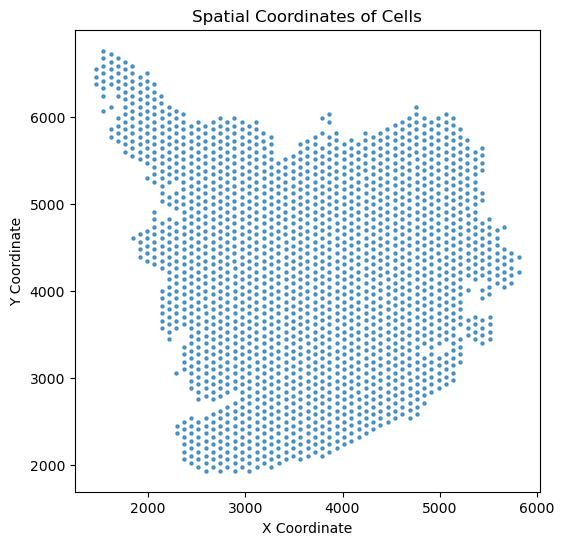

In [52]:
plt.figure(figsize=(6,6))
plt.scatter(adata.obs["x"], adata.obs["y"], s=5, alpha=0.7)
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Spatial Coordinates of Cells")
plt.show()

In [53]:
adata = sc.read_visium(dpath)
adata.var_names_make_unique()

/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [54]:
#sce.normalize_pearson_residuals(adata) # did not look good, lots of negative values
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(
    adata, key_added="clusters", flavor="igraph", directed=False, n_iterations=2
)

#sc.pp.scale(adata)
#sc.tl.pca(adata)
#sc.pp.highly_variable_genes(adata)

/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 33538 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


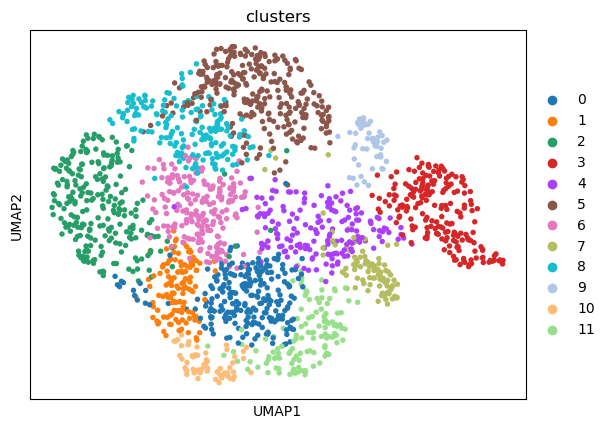

In [55]:
sc.pl.umap(adata, color=["clusters"], wspace=0.4)

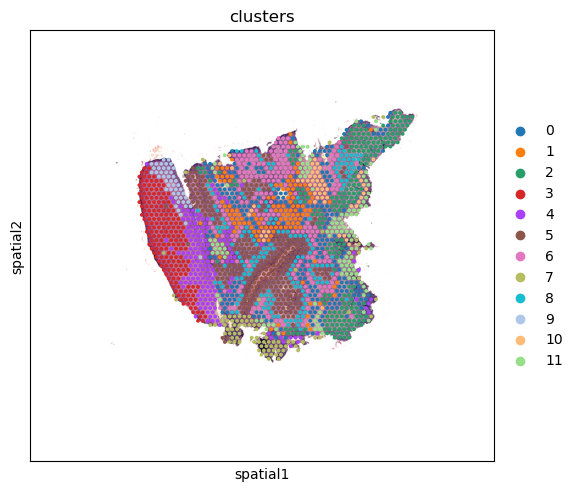

In [56]:
sq.pl.spatial_scatter(adata, color="clusters", size=1.2)

In [57]:
adata.X[:,:]

<1937x33538 sparse matrix of type '<class 'numpy.float32'>'
	with 5393460 stored elements in Compressed Sparse Row format>

In [58]:
# Convert sparse matrix to dense first
adata.X = adata.X.toarray() if sp.issparse(adata.X) else adata.X

# Compute the number of nonzero expressions per gene
Y_sums = np.array(np.sum(adata.X > 0, axis=0)).flatten()  # Ensure it's a 1D array

# Select genes expressed in more than 100 cells
Y = adata.X[:, Y_sums > 100]

print(Y.shape)  # Should now be valid
X = adata.obsm['spatial']

(1937, 10607)


In [59]:
# Set up NMF
L = 10
max_iter = 100
nmf_model = NMF(n_components=L, max_iter=max_iter, init='nndsvd', random_state=0, alpha_H=2e-1, alpha_W=1e-7)

In [60]:
Y.shape

(1937, 10607)

In [61]:
nmf_model.fit(Y)

/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


NMF(alpha_H=0.2, alpha_W=1e-07, init='nndsvd', max_iter=100, n_components=10,
    random_state=0)

In [62]:
exp_factors = nmf_model.transform(Y)

In [63]:
factors = np.log(exp_factors + 1e-2)
loadings = nmf_model.components_.T

In [64]:
moran_idx, moranI = exp.dims_autocorr(np.exp(factors), X)

In [65]:
factors_ordered=factors[:, moran_idx]
loadings_ordered=loadings[:, moran_idx]

In [66]:
def plot_factors(factors, X, moran_idx=None, ax=None, size=7, alpha=0.8, s=0.1, names=None):
    max_val = np.percentile(factors, 95)
    min_val = np.percentile(factors, 5)

    
    if moran_idx is not None:
        factors = factors[moran_idx]
        if names is not None:
            names = names[moran_idx]

    L = len(factors)

    if ax is None:
        fig, ax = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)
        
    for i in range(L):
        plt.subplot(L//5, 5, i+1)
        
        curr_ax = ax[i//5][i%5]
        
        curr_ax.scatter(X[:, 0], X[:,1], c=factors[i], vmin=min_val, vmax=max_val, alpha=alpha, cmap='turbo', s=s)

        curr_ax.invert_yaxis()
        if names is not None:
            curr_ax.set_title(names[i], x=0.03, y=.88, fontsize="small", c="white",
                     ha="left", va="top")
        curr_ax.set_xticks([])
        curr_ax.set_yticks([])
        curr_ax.set_facecolor('xkcd:gray')

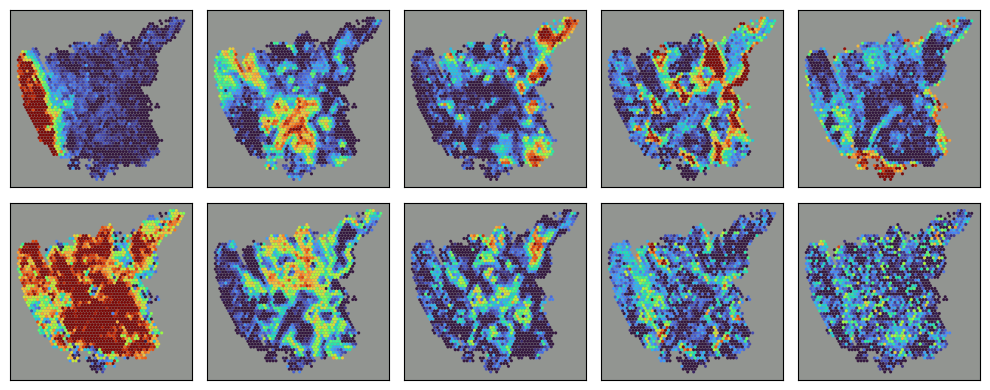

In [67]:
##### Check initialization
size=2
fig, axes = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)
plot_factors(np.exp(factors_ordered).T, X, moran_idx=None, size=2, s=1.5, alpha=0.9, ax=axes)

In [68]:
steps = 2000
model_type = 'VNNGP'
batched = True

In [69]:
#X = torch.tensor(X, dtype=torch.float)
#Y = torch.tensor(Y.T, dtype=torch.float)

In [70]:
#print(X.shape, np.float64)
#print(Y.shape, np.float64)

In [71]:
print(factors.shape)
print(loadings.shape)

(1937, 10)
(10607, 10)


In [72]:
dicts = {
    'L': L, 
    'M': X.shape[0], 
    'K': 8,
    'sigma': 0.03, 
    'lengthscale': 0.05, 
    'jtr': 1e-1,
    'batch_size': 128,
    'lr': 1e-3,
    'rs': 256,
    'lkzz_build': 1,
    'model': 'VNNGP',
    'L1_jitter' : 1e-3,
}
            
factors = np.array(factors_ordered)
loadings = np.array(loadings_ordered)

In [93]:
X = np.array(X, np.float64)
Y = np.array(Y, np.float64)
#X = rescale_spatial_coords(X)
# Min Max Rescaling
X_min = X.min()
X_max = X.max()
X = (X - X_min) / (X_max - X_min)

In [97]:
X.mean()

0.46712066918203066

In [98]:
model = exp.build_model(X, Y, loadings=loadings, factors=factors, model_type=model_type, kwargs=dicts)

In [99]:
exp.model_grads(model)
model.prior.jitter=dicts['jtr']
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=dicts['lr'])

In [100]:
model.to(device)
#X = torch.tensor(X).type(torch.float)
#Y = torch.tensor(Y).type(torch.float)
#X_train = X.to(device)

NSF2(
  (prior): VNNGP(
    (kernel): NSF_RBF()
  )
)

In [101]:
def generator():
  while True:
    yield

In [105]:
Y = Y.T

In [106]:
X.mean()

0.46712066918203066

In [107]:
Y.mean()

0.23965443929696315

In [108]:
start_time = time.time()
#X = torch.tensor(X, dtype=torch.float).to(device)
#Y = torch.tensor(Y, dtype=torch.float).to(device)

losses = []
means = []
scales = []
idxs = []

for _ in tqdm(range(2000)):
    idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=dicts['batch_size'], replacement=False)
    optimizer.zero_grad()
    pY, qF, qU, pU = model.forward_batched(X=torch.tensor(X, dtype=torch.float).to(device), idx=idx, E=20, verbose=False, kwargs=dicts)
    
    # Ensure Y is a torch tensor
    Y = torch.tensor(Y, dtype=torch.float, device=device)  # Convert NumPy array to tensor
    
    Y = Y.clone().detach()
    # Now the multiplication should work
    logpY = Y[:, idx] * torch.log(pY.rate) - (pY.rate).to(device)

    ELBO = ((logpY).mean(axis=0).sum()).to(device)
    ELBO -= torch.sum(torch.vmap(exp.vnngp_kl)(qU.mean, qU.scale_tril, model.prior.Lu, model.prior.mu))

    loss = -ELBO
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    if (_%10)==0:
            means.append(torch.exp(qF.mean.detach().cpu()).numpy())
            scales.append(qF.scale.detach().cpu().numpy())


with torch.no_grad():
    if device.type=='cuda':
        torch.cuda.empty_cache()
    
end_time = time.time()

  0%|                                                                                                                      | 0/2000 [00:00<?, ?it/s]/engelhardt/home/pshrestha/vnngp/GPzoo/gpzoo/gp.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  little_Kzz = torch.tensor(little_Kzz, device=Kzz.device).float()
  0%|                                                                                                              | 1/2000 [00:00<08:34,  3.89it/s]/tmp/ipykernel_1970874/942525197.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y, dtype=torch.float, device=device)  # Convert NumPy array to tensor
100%|████████████████████████████████████████████████████████

In [137]:
for _ in tqdm(range(12000)):
    idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=dicts['batch_size'], replacement=False)
    optimizer.zero_grad()
    pY, qF, qU, pU = model.forward_batched(X=torch.tensor(X, dtype=torch.float).to(device), idx=idx, E=20, verbose=False, kwargs=dicts)
    
    # Ensure Y is a torch tensor
    Y = torch.tensor(Y, dtype=torch.float, device=device)  # Convert NumPy array to tensor
    
    Y = Y.clone().detach()
    # Now the multiplication should work
    logpY = Y[:, idx] * torch.log(pY.rate) - (pY.rate).to(device)

    ELBO = ((logpY).mean(axis=0).sum()).to(device)
    ELBO -= torch.sum(torch.vmap(exp.vnngp_kl)(qU.mean, qU.scale_tril, model.prior.Lu, model.prior.mu))

    loss = -ELBO
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    if (_%10)==0:
            means.append(torch.exp(qF.mean.detach().cpu()).numpy())
            scales.append(qF.scale.detach().cpu().numpy())


with torch.no_grad():
    if device.type=='cuda':
        torch.cuda.empty_cache()
    
end_time = time.time()

  0%|                                                                                                                     | 0/12000 [00:00<?, ?it/s]/tmp/ipykernel_1970874/2182697790.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y, dtype=torch.float, device=device)  # Convert NumPy array to tensor
 67%|███████████████████████████████████████████████████████████████████████▏                                  | 8066/12000 [34:52<17:00,  3.85it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



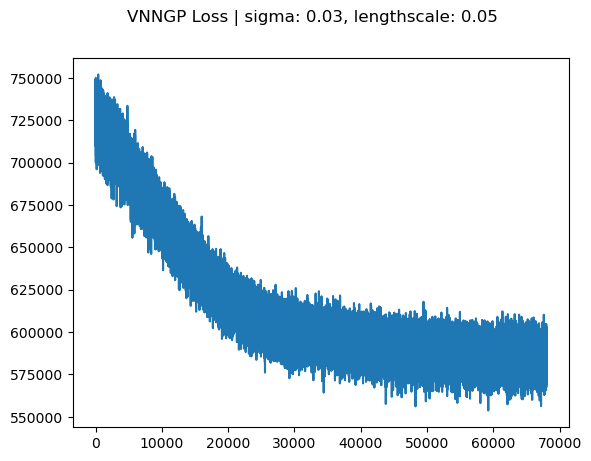

In [138]:
fig, ax = plt.subplots()
ax.plot(losses)
fig.suptitle(f"{model_type} Loss | sigma: {dicts['sigma']}, lengthscale: {dicts['lengthscale']}")
plt.show()

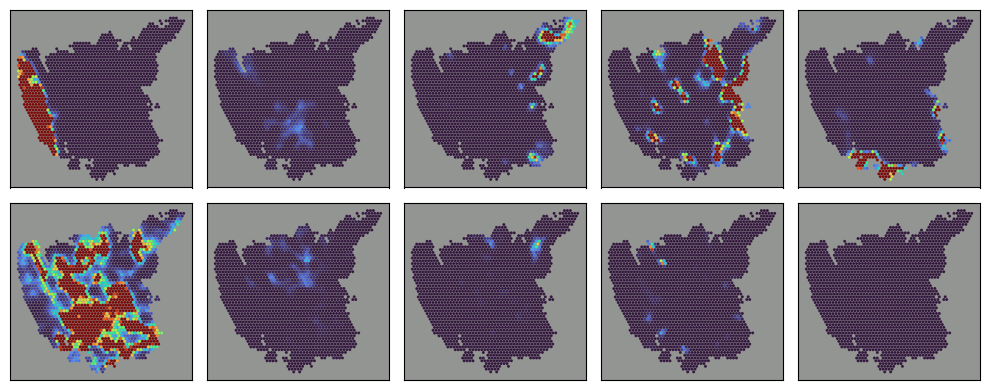

In [139]:
model.cpu()
qF, _, _ = model.prior(torch.tensor(X, dtype=torch.float).to(device), kwargs=dicts)
mean = torch.exp(qF.mean).detach().numpy()
fig, axes = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)
plot_factors(np.exp(mean), X, moran_idx=None, size=2, s=1.2, alpha=0.9, ax=axes)

In [111]:
# how many genes are there

In [140]:
model.cpu()  # Move the model to CPU if it's on GPU

NSF2(
  (prior): VNNGP(
    (kernel): NSF_RBF()
  )
)

In [141]:
model_path = path.join(root_path, 'models')

In [142]:
spath = path.join(model_path, "glioblastoma_sigma=0.03_ls=0.05_k=8.pth")
torch.save(model.state_dict(), spath)  # Save model state_dict

In [143]:
qF, _, _ = model.prior(torch.tensor(X, dtype=torch.float).to(device), kwargs=dicts)
mean = torch.exp(qF.mean).detach().numpy()

In [144]:
qF.mean

tensor([[-5.4076e-03, -5.3940e-03,  2.6359e+00,  ..., -4.9478e-03,
          1.7022e+00,  2.7136e+00],
        [-6.8244e-03,  1.2563e+00,  1.6576e-01,  ...,  6.8979e-01,
         -6.0552e-03,  3.9937e-01],
        [ 8.6919e-01,  2.2051e+00, -3.9953e-03,  ...,  8.0646e-01,
         -3.8261e-03, -4.7840e-03],
        ...,
        [-5.7063e-03,  3.8814e-01,  1.5014e-01,  ...,  6.4596e-01,
          6.1273e-01,  5.8299e-01],
        [ 1.0931e+00, -2.1013e-03,  3.9579e-01,  ...,  3.4116e-01,
          1.4067e+00,  1.6926e-01],
        [ 1.3667e-04,  1.0664e-05, -7.7054e-06,  ...,  1.0403e-04,
         -1.8285e-04,  7.1875e-05]], grad_fn=<ViewBackward0>)

In [114]:
qF.mean.shape

torch.Size([10, 1937])

In [47]:
#grad_x = zeros_like(N)  
#grad_y = zeros_like(N) 

#for i in range(z):
    # Step 3: Get the current coordinate (x, y) from Z
    #x_i, y_i = Z[i]
    
    # Step 4: Calculate the finite difference approximation for gradients
    #if i > 0 and i < z - 1 # ignore the boundaries
        #grad_x[i] = (N[i + 1, :] - N[i - 1, :]) / (Z[i + 1, 0] - Z[i - 1, 0])  # x-gradient
        #grad_y[i] = (N[i + 1, :] - N[i - 1, :]) / (Z[i + 1, 1] - Z[i - 1, 1])  # y-gradient

#return grad_x, grad_y

In [48]:
X.shape

(1937, 2)

In [49]:
Y.shape

torch.Size([10607, 1937])

In [50]:
# if we have K spots and p genes 
# dimension 2p
# sample size k